## Imports

In [1]:
import functools

from clu import metric_writers
import numpy as np
import jax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn

2024-02-15 17:31:16.936451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Example - training a conditional diffusion model

Alternatively, we can directly *train a conditional model*, where the conditional signal is provided at training time as an additional input to the denoising neural network, which may then use it to compute the denoised target.

### Dataset

Besides the sample in `x`, the dataset for training conditional models require a `cond` key which contains the condition signals.

In [2]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Batch size.
BATCH_SIZE = 16

# Number of training datapoints.
NTRAIN = 18000

# Number of testing datapoints.
NTEST = 2000

# Total number
NTOTAL = NTRAIN + NTEST

In [3]:
#name = 'Data/traindata_smooth_sigma_0.04'
name = 'Data/traindata_shepp_logan'
#name = 'Data/traindata_L4s5_multifreq_ns10_square_10h_freq_2.5_5_10'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTOTAL, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTOTAL)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTOTAL, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTOTAL, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTOTAL, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTOTAL, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTOTAL, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTOTAL, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)

    # Combine real and imaginary parts
    scatter_ = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [4]:
scatter = np.swapaxes(np.swapaxes(np.swapaxes(scatter_,1,2),2,3),3,4)
assert scatter.shape == (NTOTAL, 80, 80, 3, 2)

In [5]:
scatter_train = np.reshape(scatter[:NTRAIN,:,:],(NTRAIN,80,80,6))
eta_re_train = np.array([eta_re[:NTRAIN,:,:]])
eta_re_train = np.swapaxes(np.swapaxes(np.swapaxes(eta_re_train,0,1),1,2),2,3)
#scatter_eta_re = np.concatenate((scatter,eta_re),axis=-1)
assert eta_re_train.shape == (NTRAIN, 80, 80, 1)
assert scatter_train.shape == (NTRAIN, 80, 80, 6)

In [6]:
scatter_train_norm = scatter_train - np.mean(scatter_train,axis=0)#/(np.std(scatter,axis=0)+ 1e-4)

In [7]:
eta_re_train_norm = eta_re_train- np.mean(eta_re_train,axis=0)#/(np.std(eta_re,axis=0)+ 1e-4)

In [8]:
assert eta_re_train_norm.shape == (NTRAIN, 80, 80, 1)
assert scatter_train_norm.shape == (NTRAIN, 80, 80, 6)

In [9]:
# To avoid tf to use GPU memory
tf.config.set_visible_devices([], device_type='GPU')

batch_size = 16
dict_data = {"x": eta_re_train_norm}
dict_data["cond"] = {"channel:scatter": scatter_train_norm}
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

2024-02-15 17:33:36.732958: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
data_std = np.std(eta_re_train_norm)

In [11]:
print(data_std)

0.08609672


### Architecture

The architecture is similar to the unconditional case. We provide additional args that specify how to resize the conditioning signal (in order to be compatible with the noisy sample for channel-wise concatenation).

In [12]:
cond_denoiser_model = dfn_lib.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=data_std,
    cond_resize_method="cubic",
    cond_embed_dim=128,
)

The `DenoisingModel` is again similar to the unconditional case. We additionally provide the shape information of the `cond` input.

In [13]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=data_std,
)

cond_model = dfn.DenoisingModel(
    input_shape=(80, 80, 1),
    # `cond_shape` must agree with the expected structure and shape
    # (without the batch dimension) of the `cond` input.
    cond_shape={"channel:scatter": (80, 80, 6)},
    denoiser=cond_denoiser_model,
    noise_sampling=dfn_lib.log_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=data_std),
)

The rest mostly repeats the unconditional training example, replacing the datasets and model with their conditional counterparts.

In [ ]:
# !rm -R -f $cond_workdir  # optional: clear the working directory

In [14]:
num_train_steps = 100000  #@param
cond_workdir = "/tmp/diffusion_cond_traindata_shepp_logan"  #@param
initial_lr = 0.0  #@param
peak_lr = 1e-4  #@param
warmup_steps = 1000  #@param
end_lr = 1e-6  #@param
ema_decay = 0.999  #@param
ckpt_interval = 1000  #@param
max_ckpt_to_keep = 5  #@param
#train_batch_size = 32  #@param
#eval_batch_size = 32  #@param

### Training

In [15]:
cond_trainer = dfn.DenoisingTrainer(
    model=cond_model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    ema_decay=ema_decay,
)

In [16]:
templates.run_train(
    train_dataloader=dataset,
    trainer=cond_trainer,
    workdir=cond_workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        cond_workdir, asynchronous=False
    ),
    metric_aggregation_steps=100,
    eval_dataloader=eval_dataloader,
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=cond_workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/100000 [00:00<?, ?step/s]

### Inference

To perform inference/sampling, let's load back the trained conditional model checkpoint:

In [17]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)

# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

The conditional sampler again follows the previous example, with the only exception being that the conditional model replaces the unconditional one.

Below we do not apply any guidance, but one can be easily added in the same way as in the unconditional example above.

In [18]:
cond_sampler = dfn_lib.SdeSampler(
    input_shape=(80, 80, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

We again JIT the generate function for the sake of faster repeated sampling calls. Here we employ `functools.partial` to specify `num_samples=5`, making it easier to vectorize across the batch dimension with `jax.vmap`.

In [19]:
num_samples_per_cond = 5

generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

Loading a test batch of conditions with 4 elements:

In [20]:
scatter_test = np.reshape(scatter[NTRAIN:,:,:],(NTEST,80,80,6))
eta_re_test = np.array([eta_re[NTRAIN:,:,:]])
eta_re_test = np.swapaxes(np.swapaxes(np.swapaxes(eta_re_test,0,1),1,2),2,3)

In [21]:
scatter_test_norm = scatter_test - np.mean(scatter_train,axis=0)

In [22]:
batch_size_test = 4
dict_data_test = {}
dict_data_test["cond"] = {"channel:scatter": scatter_test_norm}
dataset_test = tf.data.Dataset.from_tensor_slices(dict_data_test)
dataset_test = dataset_test.repeat()
dataset_test = dataset_test.batch(batch_size_test)
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.as_numpy_iterator()
test_batch_cond = next(iter(dataset_test))["cond"]

The vectorized generate function is applied to the loaded batch. The vectorization occurs for the leading dimensions of both the random seed and the condition (for those unfamiliarized with vectorized operations in jax, think of a more efficient `for` loop that iterates over the random seeds and batch conditions zipped together).

In [23]:
cond_samples = jax.vmap(generate, in_axes=(0, 0, None))(
    jax.random.split(jax.random.PRNGKey(8888), batch_size_test),
    test_batch_cond,
    None,  # Guidance inputs = None since no guidance transforms involved
)

The result `cond_samples` has shape `(batch_size, num_samples_per_cond, *input_shape)`.

In [24]:
print(cond_samples.shape)

(4, 5, 80, 80, 1)


In [25]:
cond_samples_denorm = np.zeros((batch_size_test,num_samples_per_cond,80,80,1))
test_batch_cond_denorm = np.zeros((batch_size_test,80,80,6))
for i in range(4):
    test_batch_cond_denorm[i,:,:,:] = test_batch_cond["channel:scatter"][i,:,:,:] + np.mean(scatter_train,axis=0)
    for j in range(5):
        cond_samples_denorm[i,j,:,:,:] = cond_samples[i,j,:,:,:] + np.mean(eta_re_train,axis=0)

In [26]:
test_batch_cond_denorm.shape

(4, 80, 80, 6)

In [27]:
dict_data_test = {}
dict_data_test["truth"] = {"eta": eta_re_test}
dataset_test = tf.data.Dataset.from_tensor_slices(dict_data_test)
dataset_test = dataset_test.repeat()
dataset_test = dataset_test.batch(batch_size_test)
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.as_numpy_iterator()
test_batch_eta = next(iter(dataset_test))["truth"]

Visualize generated examples alongside their low-res conditioning:

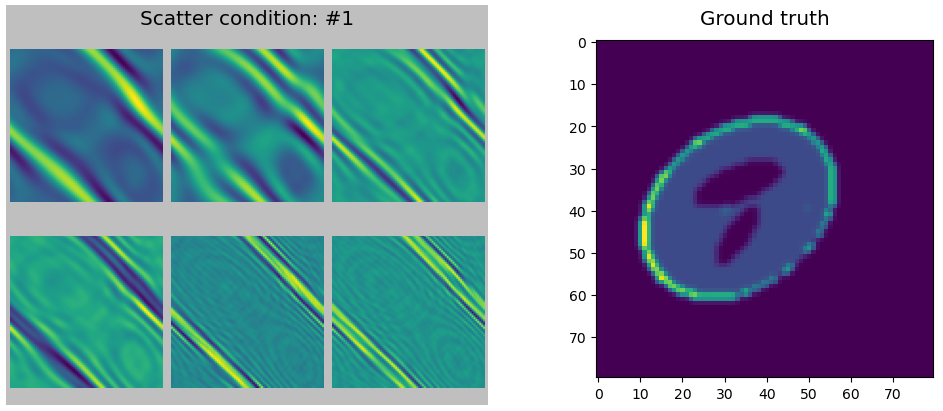

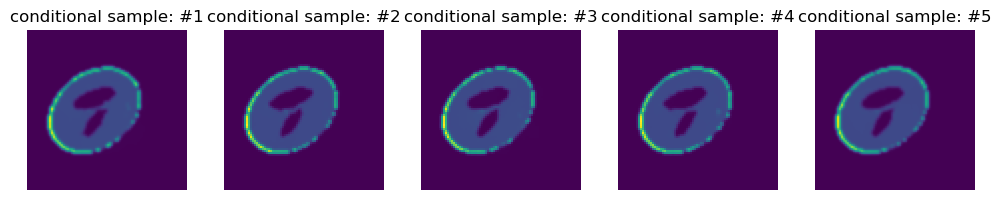

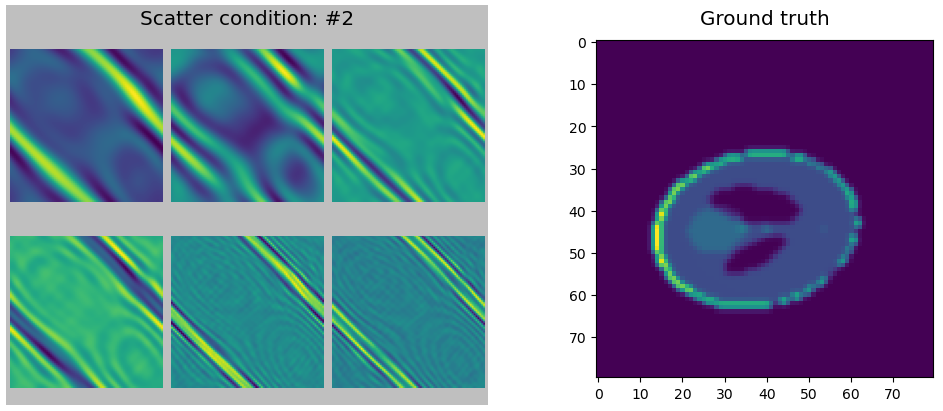

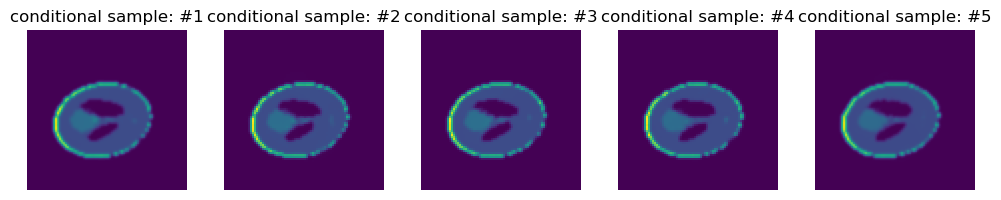

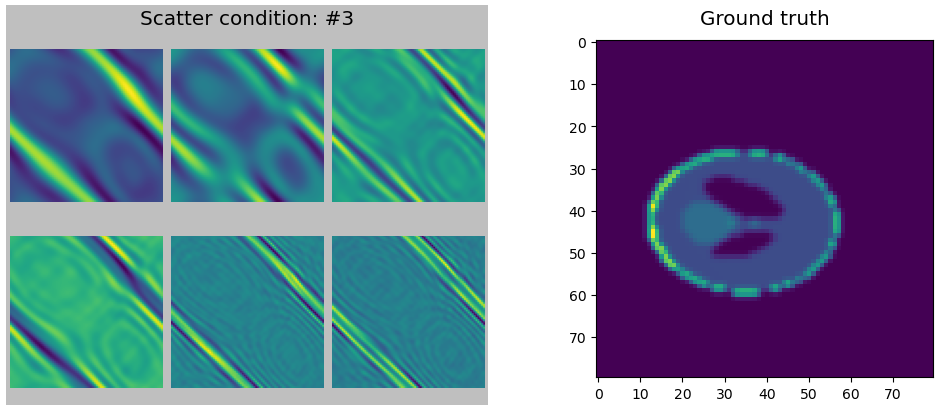

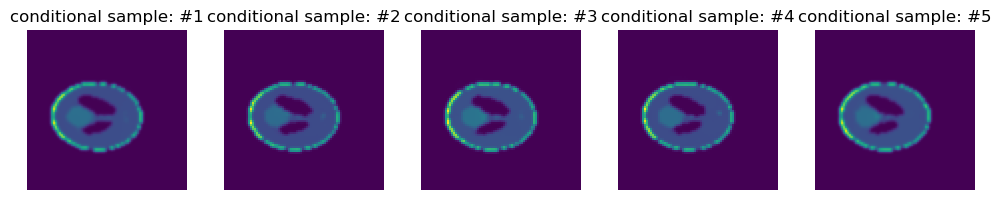

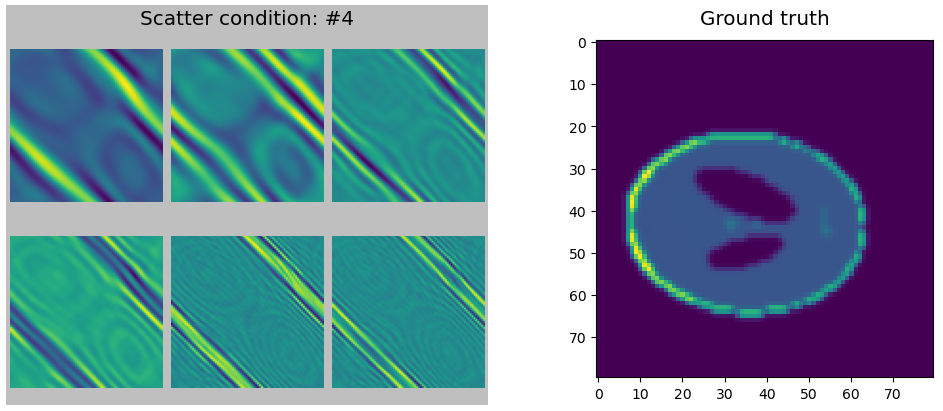

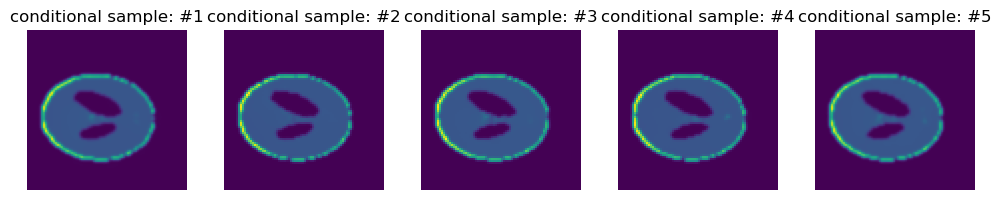

In [28]:
for i in range(batch_size_test):
    fig = plt.figure(layout='constrained', figsize=(10, 4))
    subfigs = fig.subfigures(1, 2, wspace=0.07)
    
    axsLeft = subfigs[0].subplots(2,3)
    subfigs[0].set_facecolor('0.75')
    l = 0
    for j in range(2):
        for k in range(3):
            im = axsLeft[j,k].imshow(test_batch_cond_denorm[i, :, :, l])#,vmin=0, vmax=255)
            #print(test_batch_cond_denorm[i, :, :, l].shape)
            l += 1
            axsLeft[j,k].axis("off")
    subfigs[0].suptitle(f"Scatter condition: #{i + 1}", fontsize='x-large')
    #subfigs[0].colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')
    
    axsRight = subfigs[1].subplots(1, 1)
    axsRight.imshow(test_batch_eta["eta"][i, :, :, 0])
    
    #subfigs[1].set_facecolor('0.85')
    #subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
    subfigs[1].suptitle('Ground truth', fontsize='x-large')
    
    #fig.suptitle('Scatter and ground truth', fontsize='xx-large')
    
    # Plot generated samples.
    fig, ax = plt.subplots(
              1, num_samples_per_cond, figsize=(num_samples_per_cond * 2, 2)
              )
    for j in range(num_samples_per_cond):
        im = ax[j].imshow(
             cond_samples_denorm[i, j, :, :, 0])# vmin=0, vmax=255)
        #square = patches.Rectangle(xy=(11, 11), width=7, height=7, fill=False, edgecolor='red')
        ax[j].set_title(f"conditional sample: #{j + 1}")
        ax[j].axis("off")
        
    plt.tight_layout()
        
    plt.show()

In [29]:
std_conds = np.zeros((batch_size_test,80,80))
for i in range(batch_size_test):
    std_conds[i,:,:] = np.std((cond_samples_denorm[i,0,:,:,0],cond_samples_denorm[i,1,:,:,0],cond_samples_denorm[i,2,:,:,0],
              cond_samples_denorm[i,3,:,:,0],cond_samples_denorm[i,4,:,:,0]), axis=0, ddof=1)

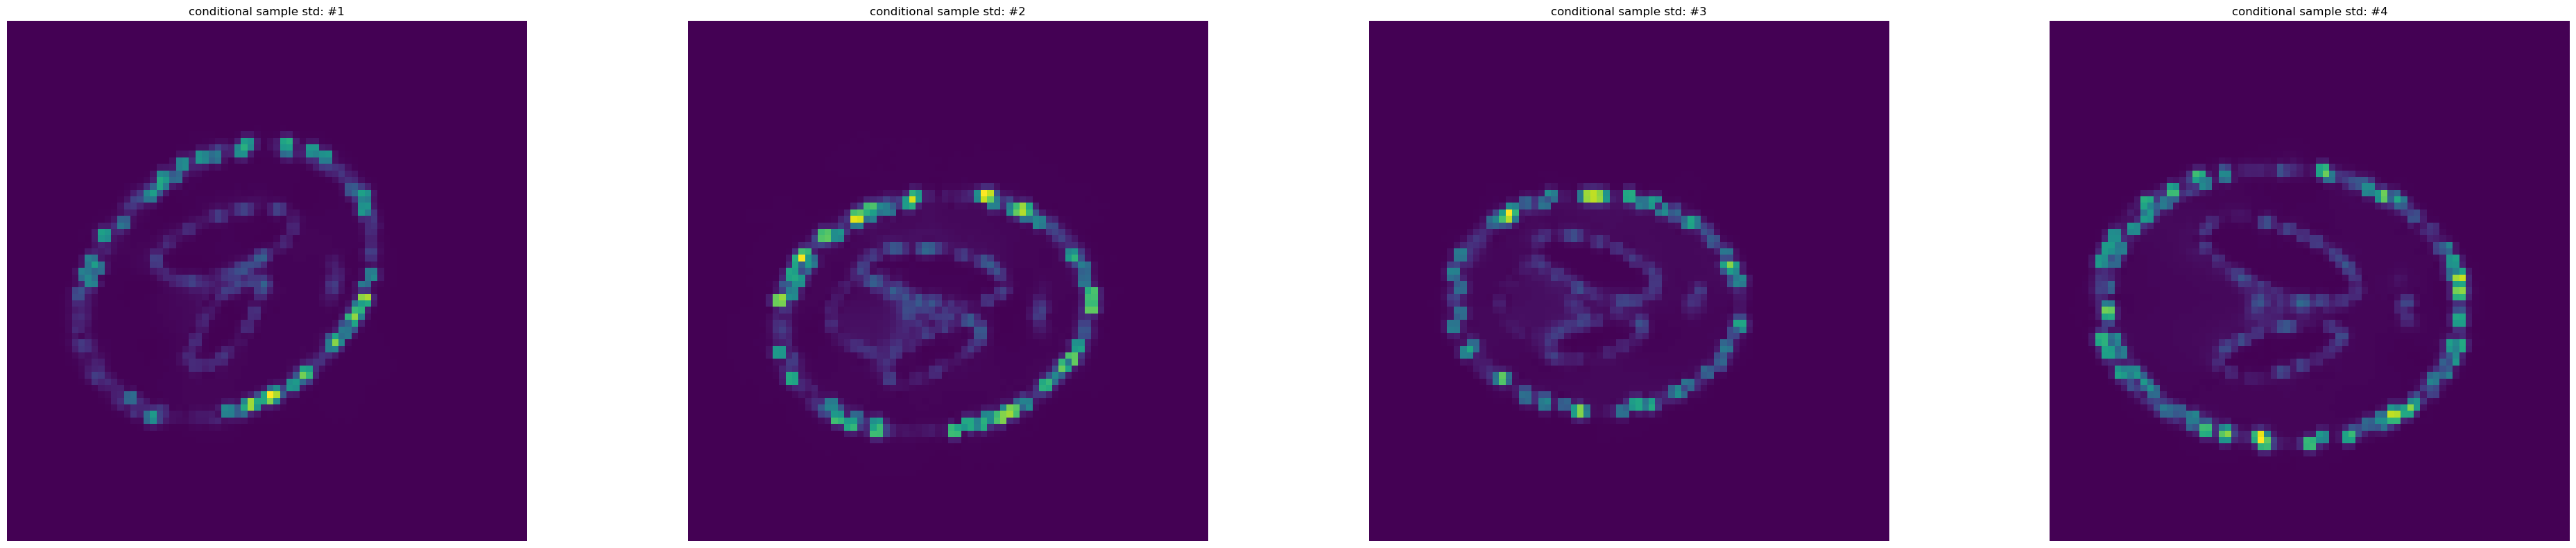

In [30]:
fig, axs = plt.subplots(1,batch_size_test,figsize=(batch_size*2.5, 8))
for i in range(batch_size_test):
    im = axs[i].imshow(std_conds[i, :, :])# vmin=0, vmax=255)
    axs[i].set_title(f"conditional sample std: #{i + 1}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()